In [24]:
import numpy as np
import pandas as pd 
import scipy as sp
import scipy.io
from scipy.stats import norm
from scipy.stats import multivariate_normal
from scipy.signal import find_peaks
from datetime import datetime
import matplotlib.dates as mdates
from matplotlib.dates import date2num, datestr2num


import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import os
import glob
import fnmatch
import re

In [2]:
df_Xerunlist = pd.read_csv('./XeArapucaRunList.csv', sep = ';')
df_Xerunlist.head()

,Run Number,Config,Day/time,Comments,Efield
0,10872,CRT_noprescale_delay_Feb00003,06/02/2020,First run after solving the noise problem. All...,False
1,10873,CRT_noprescale_delay_Feb00003,06/02/2020,Started using CRT trigger. Biases for channels...,False
2,10874,CRT_noprescale_delay_Feb00003,06/02/2020,"Biases for channels 0,6 and 8 to 11 of SSP 504...",False
3,10875,CRT_noprescale_delay_Feb00003,06/02/2020,Biases for channels 0 to 7 of SSP 504 brought ...,False
4,10877,XeDope_CRT_noprescale_delay_Feb00002,06/02/2020,New config with lower disc thresholds (70 ADC ...,False


In [3]:
## add time infos
df_Xetimelist = pd.read_csv('./timeinfos.txt', sep = '\t', header=None, names={'Run Number', 'daytime'})
df_Xetimelist['daytime'] = pd.to_datetime(df_Xetimelist['daytime'])
df_Xetimelist = df_Xetimelist.sort_values(by=['Run Number'] ).drop_duplicates(ignore_index = True)
df_Xetimelist.head()

,Run Number,daytime
0,10872,2020-02-06 13:51:48+00:00
1,10873,2020-02-06 14:03:28+00:00
2,10874,2020-02-06 14:25:00+00:00
3,10875,2020-02-06 15:38:58+00:00
4,10877,2020-02-06 16:06:42+00:00


In [4]:
df_tmp = pd.merge(df_Xerunlist, df_Xetimelist, how = 'inner', on=['Run Number'])

df_Xerunlist_info = df_tmp[['Run Number', 'Day/time', 'daytime', 'Efield']]
df_Xerunlist_info['Day/time'] = pd.to_datetime(df_Xerunlist_info['Day/time'], format='%d/%m/%Y')
df_Xerunlist_info['Day/time'] = df_Xerunlist_info['Day/time'].dt.strftime('%d %b')
df_Xerunlist_info.head()



,Run Number,Day/time,daytime,Efield
0,10872,06 Feb,2020-02-06 13:51:48+00:00,False
1,10873,06 Feb,2020-02-06 14:03:28+00:00,False
2,10874,06 Feb,2020-02-06 14:25:00+00:00,False
3,10875,06 Feb,2020-02-06 15:38:58+00:00,False
4,10877,06 Feb,2020-02-06 16:06:42+00:00,False


# Read my files and do the analysis


In [5]:
# read APA 3 files 

base_path_mod304 = '/Users/bordoni/protoDUNE/XeDoping/Arapuca/fnal_results/infiles08052020_mod304/Integral'
file_path_mod304 = os.path.join(base_path_mod304,'CalibratedIntegral_*.csv')

file_name_list_mod304 =  glob.glob(file_path_mod304) 
print('APA 3: Getting infos from ', len(file_name_list_mod304), 'runs ')


# read APA 6 files 

base_path_mod603 = '/Users/bordoni/protoDUNE/XeDoping/Arapuca/fnal_results/infiles08052020_mod603/Integral'
file_path_mod603 = os.path.join(base_path_mod603,'CalibratedIntegral_*.csv')

file_name_list_mod603 =  glob.glob(file_path_mod603) 
print('APA 6: Getting infos from ', len(file_name_list_mod603), 'runs ')


APA 3: Getting infos from  97 runs 
APA 6: Getting infos from  76 runs 


In [6]:
def readfile_list(filename_list):       
    
    def read_single_file(f):
        data = pd.read_csv(f, index_col=0)
        return data
    
    data_list = [read_single_file(f) for f in filename_list]
    return pd.concat(data_list, axis=0)
    

In [7]:
df_304 = readfile_list(file_name_list_mod304)
df_603 = readfile_list(file_name_list_mod603)


display(df_304.head())

display(df_603.head())


,Run number,Ch,Integral,pe area_mean,pe area_std,f_cal,n good evts
0,11021,0,7554.093236,475.629607,164.225912,1.000000,10620
1,11021,1,5965.158716,473.798684,163.436650,0.996151,10694
2,11021,2,6811.382174,478.290037,163.970221,1.005593,10659
3,11021,3,5707.479941,491.526595,165.134200,1.033423,10700
4,11021,4,13929.721287,477.829584,163.054736,1.004625,4830


,Run number,Ch,Integral,pe area_mean,pe area_std,f_cal,n good evts
0,11021,0,5534.322105,438.797034,144.886754,1.000000,6804
1,11021,1,14117.131841,450.359705,152.530278,1.026351,2504
2,11021,2,13022.030469,448.850498,143.627997,1.022911,2385
3,11021,3,15045.207965,415.431604,156.352321,0.946751,2247
4,11021,4,7202.065870,444.835992,145.092221,1.013763,6747


In [8]:
#create df apa3 for the integral

df_integral_304 = df_304.groupby(['Run number'])['Integral'].sum().to_frame().reset_index()
stat  = np.sqrt(df_304.groupby(['Run number'])['n good evts'].sum())
df_integral_304['stat err'] = stat.values
df_integral_304.rename(columns={'Run number': 'Run Number'}, inplace=True)
df_integral_304.head()

,Run Number,Integral,stat err
0,10877,143112.006752,167.263266
1,10878,134258.434941,177.208916
2,10879,146913.710598,163.000000
3,10885,138948.518489,142.635900
4,10903,142025.626576,163.187009


In [9]:
df_apa3 = pd.merge(df_Xerunlist_info, df_integral_304, how = 'inner', on=['Run Number'])
df_apa3.head()

,Run Number,Day/time,daytime,Efield,Integral,stat err
0,10877,06 Feb,2020-02-06 16:06:42+00:00,False,143112.006752,167.263266
1,10878,06 Feb,2020-02-06 17:20:49+00:00,False,134258.434941,177.208916
2,10879,06 Feb,2020-02-06 18:27:43+00:00,False,146913.710598,163.000000
3,10885,07 Feb,2020-02-07 10:59:21+00:00,False,138948.518489,142.635900
4,10903,08 Feb,2020-02-08 09:40:06+00:00,False,142025.626576,163.187009


In [10]:
#create df apa6 for the integral

df_integral_603 = df_603.groupby(['Run number'])['Integral'].sum().to_frame().reset_index()
stat  = np.sqrt(df_603.groupby(['Run number'])['n good evts'].sum())
df_integral_603['stat err'] = stat.values
df_integral_603.rename(columns={'Run number': 'Run Number'}, inplace=True)

df_apa6 = pd.merge(df_Xerunlist_info, df_integral_603, how = 'inner', on=['Run Number'])
df_apa6.head()


,Run Number,Day/time,daytime,Efield,Integral,stat err
0,10906,09 Feb,2020-02-09 09:38:25+00:00,False,117264.588563,80.901174
1,10907,09 Feb,2020-02-09 13:08:44+00:00,False,136793.434553,125.582642
2,10909,09 Feb,2020-02-09 20:41:41+00:00,False,127661.812705,76.111760
3,10915,10 Feb,2020-02-10 08:53:11+00:00,False,167335.857995,54.304696
4,10922,10 Feb,2020-02-10 15:40:03+00:00,False,140715.673310,38.223030


In [11]:
df_apa6['daytime'] = pd.to_datetime(df_apa6['daytime'], format='%d/%m/%Y')
#df_apa6['daytime'] = df_apa6['daytime'].dt.strftime('%d %b : %I %p')
df_apa6.head()

df_apa3['daytime'] = pd.to_datetime(df_apa3['daytime'], format='%d/%m/%Y')
#df_apa3['daytime'] = df_apa3['daytime'].dt.strftime('%d %b : %I %p')
df_apa3.head()


,Run Number,Day/time,daytime,Efield,Integral,stat err
0,10877,06 Feb,2020-02-06 16:06:42+00:00,False,143112.006752,167.263266
1,10878,06 Feb,2020-02-06 17:20:49+00:00,False,134258.434941,177.208916
2,10879,06 Feb,2020-02-06 18:27:43+00:00,False,146913.710598,163.000000
3,10885,07 Feb,2020-02-07 10:59:21+00:00,False,138948.518489,142.635900
4,10903,08 Feb,2020-02-08 09:40:06+00:00,False,142025.626576,163.187009


In [12]:
#define doping periods and corresponding df 
df_apa3_pre = df_apa3.loc[(df_apa3['Run Number'] < 10943)] 
df_apa3_dop_1 = df_apa3.loc[(df_apa3['Run Number'] >= 10943) & (df_apa3['Run Number'] <= 11008) ] 
df_apa3_dop_2 = df_apa3.loc[(df_apa3['Run Number'] >= 11009) & (df_apa3['Run Number'] <= 11101) ]
df_apa3_dop_3 = df_apa3.loc[(df_apa3['Run Number'] >= 11102) & (df_apa3['Run Number'] <= 11143) ]
df_apa3_dop_4 = df_apa3.loc[(df_apa3['Run Number'] >= 11145) & (df_apa3['Run Number'] <= 11244) ]
df_apa3_dop_5 = df_apa3.loc[(df_apa3['Run Number'] >= 11245) ]




#define doping periods and corresponding df 
df_apa6_pre = df_apa6.loc[(df_apa6['Run Number'] < 10943)] 
df_apa6_dop_1 = df_apa6.loc[(df_apa6['Run Number'] >= 10943) & (df_apa6['Run Number'] <= 11008) ] 
df_apa6_dop_2 = df_apa6.loc[(df_apa6['Run Number'] >= 11008) & (df_apa6['Run Number'] <= 11101) ]
df_apa6_dop_3 = df_apa6.loc[(df_apa6['Run Number'] >= 11102) & (df_apa6['Run Number'] <= 11143) ]
df_apa6_dop_4 = df_apa6.loc[(df_apa6['Run Number'] >= 11145) & (df_apa6['Run Number'] <= 11244) ]
df_apa6_dop_5 = df_apa6.loc[(df_apa6['Run Number'] >= 11245) ]






In [13]:
df_apa3_dop_2

,Run Number,Day/time,daytime,Efield,Integral,stat err
29,11013,27 Feb,2020-02-27 16:37:52+00:00,False,108863.479248,301.176028
30,11014,28 Feb,2020-02-28 05:03:33+00:00,False,125450.046447,328.233149
31,11015,28 Feb,2020-02-28 14:39:57+00:00,False,145058.638590,312.529999
32,11016,29 Feb,2020-02-28 22:25:04+00:00,False,154175.057335,278.591098
33,11017,29 Feb,2020-02-29 10:36:43+00:00,False,118375.598498,320.926783
34,11018,01 Mar,2020-02-29 22:01:25+00:00,False,165577.679557,265.904118
35,11021,02 Mar,2020-03-01 22:30:38+00:00,False,130891.243951,311.462678
36,11092,16 Mar,2020-03-16 12:50:25+00:00,False,139865.222488,283.959504
37,11101,02 Apr,2020-04-02 13:56:12+00:00,False,168039.111719,281.480017


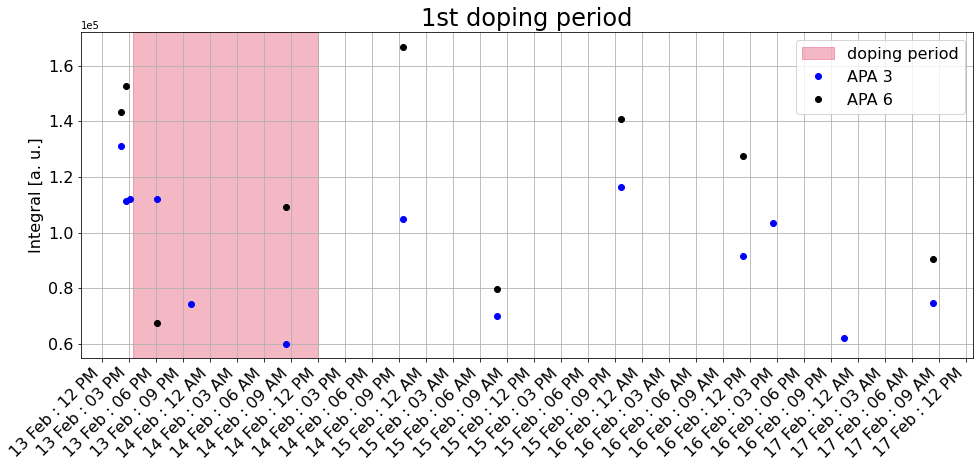

In [27]:
############################################################
#                           DOPING 1  
############################################################


fig = plt.figure(figsize=(16,6))

plt.title('1st doping period', fontsize=24)
plt.errorbar(x=df_apa3_dop_1['daytime'], y=df_apa3_dop_1['Integral'], fmt='o', color='blue', ecolor='lightgray', elinewidth=3, capsize=0, label = 'APA 3')
plt.errorbar(x=df_apa6_dop_1['daytime'], y=df_apa6_dop_1['Integral'], fmt='o', color='black', ecolor='lightgray', elinewidth=3, capsize=0, label = 'APA 6')


ax = plt.axes()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b : %I %p'))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=3))   #to get a tick every 15 minutes


plt.ylabel('Integral [a. u.]', fontsize=16)
plt.ticklabel_format(axis='y', style="sci", scilimits=(0,0))
plt.xticks(rotation=45, fontsize=16, horizontalalignment="right")
plt.yticks(fontsize=16)

plt.axvspan(datestr2num('13 Feb 3:30pm'), datestr2num('14 Feb 12:00pm '),    label="doping period", color="crimson", alpha=0.3)


plt.legend(fontsize=16)

plt.grid()
plt.show()

fig.savefig('./Integral_1stdop.pdf')


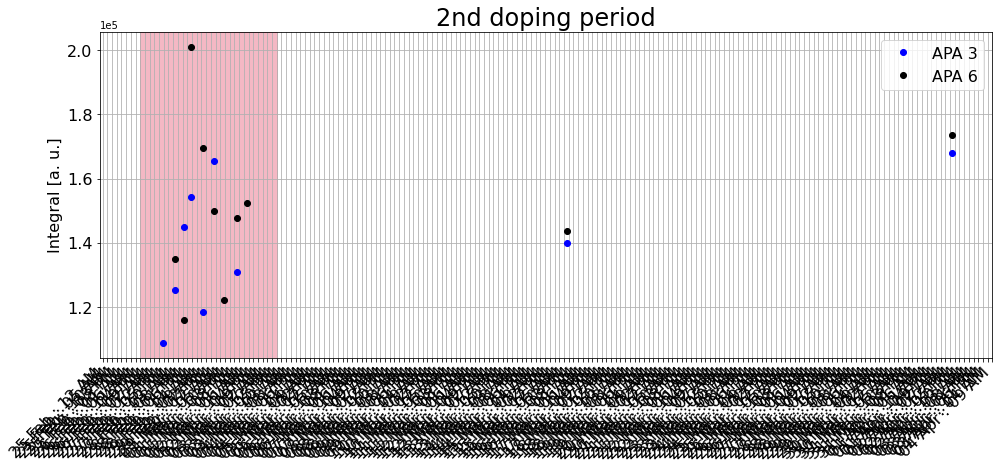

In [29]:
############################################################
#                           DOPING 2  
############################################################


fig = plt.figure(figsize=(16,6))

plt.title('2nd doping period', fontsize=24)
plt.errorbar(x=df_apa3_dop_2['daytime'], y=df_apa3_dop_2['Integral'], fmt='o', color='blue', ecolor='lightgray', elinewidth=3, capsize=0, label = 'APA 3')
plt.errorbar(x=df_apa6_dop_2['daytime'], y=df_apa6_dop_2['Integral'], fmt='o', color='black', ecolor='lightgray', elinewidth=3, capsize=0, label = 'APA 6')

ax = plt.axes()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b : %I %p'))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=5))   #to get a tick every 3 Hours

plt.axvspan(datestr2num('26 Feb 4:00pm'), datestr2num('3 March 5:00 pm'),   color="crimson", alpha=0.3)


plt.ylabel('Integral [a. u.]', fontsize=16)
plt.ticklabel_format(axis='y', style="sci", scilimits=(0,0))
plt.xticks(rotation=45, fontsize=16, horizontalalignment="right")
plt.yticks(fontsize=16)

plt.legend(fontsize=16)

plt.grid()

fig.savefig('./Integral_2nddop.pdf')


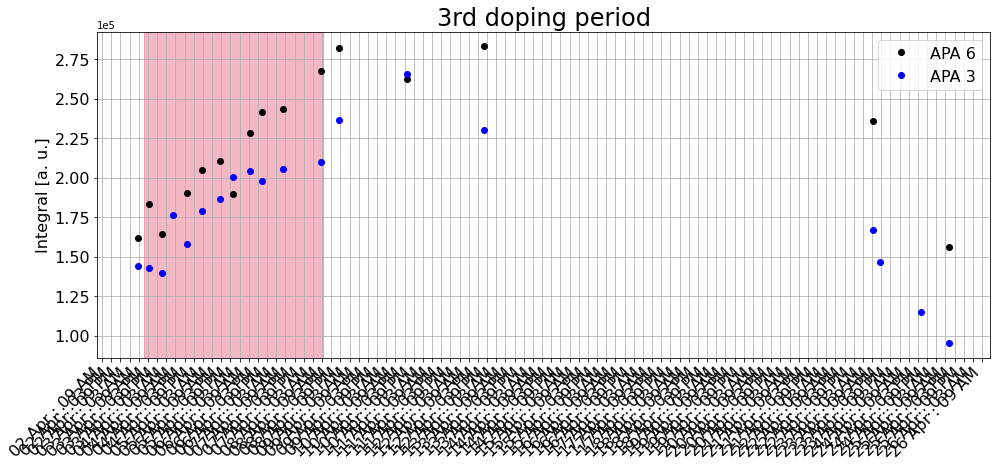

In [32]:
############################################################
#                           DOPING 3  
############################################################


fig = plt.figure(figsize=(16,6))

plt.title('3rd doping period', fontsize=24)
plt.errorbar(x=df_apa6_dop_3['daytime'], y=df_apa6_dop_3['Integral'], fmt='o', color='black', ecolor='lightgray', elinewidth=3, capsize=0, label = 'APA 6')
plt.errorbar(x=df_apa3_dop_3['daytime'], y=df_apa3_dop_3['Integral'], fmt='o', color='blue', ecolor='lightgray', elinewidth=3, capsize=0, label = 'APA 3')

ax = plt.axes()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b : %I %p'))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=6))   #to get a tick every 3 Hours

plt.axvspan(datestr2num('3 Apr 12:30pm'), datestr2num('8 Apr 9:30 am'),   color="crimson", alpha=0.3)


plt.ylabel('Integral [a. u.]', fontsize=16)
plt.ticklabel_format(axis='y', style="sci", scilimits=(0,0))
plt.xticks(rotation=45, fontsize=16, horizontalalignment="right")
plt.yticks(fontsize=16)

plt.legend(fontsize=16)

plt.grid()
fig.savefig('./Integral_3rddop.pdf')


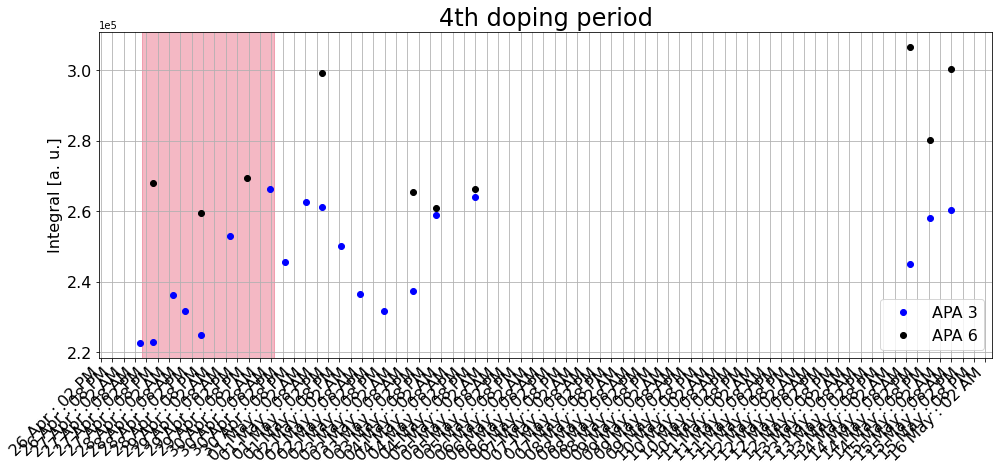

In [33]:
############################################################
#                           DOPING 4  
############################################################


fig = plt.figure(figsize=(16,6))

plt.title('4th doping period', fontsize=24)
plt.errorbar(x=df_apa3_dop_4['daytime'], y=df_apa3_dop_4['Integral'], fmt='o', color='blue', ecolor='lightgray', elinewidth=3, capsize=0, label = 'APA 3')
plt.errorbar(x=df_apa6_dop_4['daytime'], y=df_apa6_dop_4['Integral'], fmt='o', color='black', ecolor='lightgray', elinewidth=3, capsize=0, label = 'APA 6')

ax = plt.axes()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b : %I %p'))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=6))   #to get a tick every 3 Hours

plt.axvspan(datestr2num('27 April 11:30am'), datestr2num('30 April 9:30am'),color="crimson", alpha=0.3)



plt.ylabel('Integral [a. u.]', fontsize=16)
plt.ticklabel_format(axis='y', style="sci", scilimits=(0,0))
plt.xticks(rotation=45, fontsize=16, horizontalalignment="right")
plt.yticks(fontsize=16)

plt.legend(fontsize=16)

plt.grid()

fig.savefig('./Integral_4thdop.pdf')


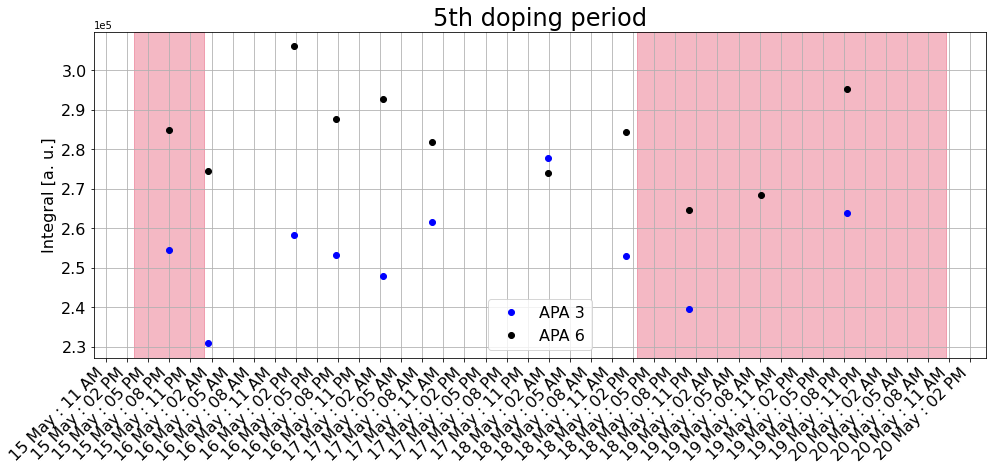

In [35]:
############################################################
#                           DOPING 5  
############################################################


fig = plt.figure(figsize=(16,6))

plt.title('5th doping period', fontsize=24)
plt.errorbar(x=df_apa3_dop_5['daytime'], y=df_apa3_dop_5['Integral'], fmt='o', color='blue', ecolor='lightgray', elinewidth=3, capsize=0, label = 'APA 3')
plt.errorbar(x=df_apa6_dop_5['daytime'], y=df_apa6_dop_5['Integral'], fmt='o', color='black', ecolor='lightgray', elinewidth=3, capsize=0, label = 'APA 6')


ax = plt.axes()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b : %I %p'))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=3))   #to get a tick every 3 Hours
plt.axvspan(datestr2num('15th May 3:00pm '), datestr2num('16 May 1:00am'),  color="crimson", alpha=0.3)
plt.axvspan(datestr2num('18th May 2:30pm '), datestr2num('20 May 10:30am'),  color="crimson", alpha=0.3)



plt.ylabel('Integral [a. u.]', fontsize=16)
plt.ticklabel_format(axis='y', style="sci", scilimits=(0,0))
plt.xticks(rotation=45, fontsize=16, horizontalalignment="right")
plt.yticks(fontsize=16)

plt.legend(fontsize=16)

plt.grid()

fig.savefig('./Integral_5thdop.pdf')